# Knapsack

In [1]:
title = 'Knapsack'

In [42]:
import mlrose_hiive

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
eval_count = 0

def knapsack(state, weights, values, max_weight_pct):
    global eval_count
    
    fitness = mlrose_hiive.Knapsack(weights, values, max_weight_pct)
    
    eval_count += 1
    
    return fitness.evaluate(state)

## test
w = [10, 5, 2, 8, 15]
v = [1, 2, 3, 4, 5]
max_w_pct = 0.6

state = np.array([1, 0, 2, 1, 0])
print('Knapsack:', knapsack(state, w, v, max_w_pct))

kwargs = {'weights':w, 'values':v, 'max_weight_pct':max_w_pct}
ffn_knapsack = mlrose_hiive.CustomFitness(knapsack, **kwargs)
state = np.array([1, 0, 2, 1, 0])
print('Custom Knapsack:', ffn_knapsack.evaluate(state))


Knapsack: 11
Custom Knapsack: 11


In [74]:
np.random.seed(1)
input_size = np.arange(6, 20, 4, dtype=np.int)

eval_cnt_df = pd.DataFrame()
eval_cnt_df['input_size'] = input_size
eval_cnt_rhc = []
eval_cnt_sa = []
eval_cnt_ga = []
eval_cnt_mimic = []

eval_time_df = pd.DataFrame()
eval_time_df['input_size'] = input_size
eval_time_rhc = []
eval_time_sa = []
eval_time_ga = []
eval_time_mimic = []

fitness_curve = {}

schedule=mlrose_hiive.ExpDecay() ## Simulated Annealing
# schedule=mlrose_hiive.ExpDecay(exp_const=.001, init_temp=2)

for n in input_size:
    ## initialize problem
    number_of_items_types=n  ## number of inputs    
    max_weight_per_item=25
    max_value_per_item=10 
    max_weight_pct=0.6
    weights = 1 + np.random.randint(max_weight_per_item, size=number_of_items_types)
    values  = 1 + np.random.randint(max_value_per_item, size=number_of_items_types)

    kwargs = {'weights':weights, 'values':values, 'max_weight_pct':max_weight_pct}
    ffn_knapsack = mlrose_hiive.CustomFitness(knapsack, **kwargs)

    init_state = np.random.randint(2, size=n)
    problem = mlrose_hiive.DiscreteOpt(length=len(init_state), fitness_fn=ffn_knapsack, 
                                       maximize=True, max_val=2)
    
    print('Custom Knapsack:', ffn_knapsack.evaluate(init_state))
    
    ## Random Hill Climbing
    eval_count = 0
    begin = datetime.now()
    rhc_state, rhc_fitness, rhc_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                 max_attempts=20, 
                                                                 max_iters=10000,
                                                                 restarts=50,
                                                                 init_state=init_state,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_rhc.append(dt.total_seconds())
    eval_cnt_rhc.append(eval_count)

    ## Simulated Annealing
    eval_count = 0
    begin = datetime.now()
    sa_state, sa_fitness, sa_curve = mlrose_hiive.simulated_annealing(problem,
                                                                   schedule=schedule,
                                                                   max_attempts=40, 
                                                                   max_iters=10000, 
                                                                   init_state=init_state,
                                                                   curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_sa.append(dt.total_seconds())
    eval_cnt_sa.append(eval_count)
    
    ## Genetic Algorithm
    eval_count = 0
    pop_size = int(n * 5)
    mute_prob = 0.1 #0.025
    begin = datetime.now()
    ga_state, ga_fitness, ga_curve =  mlrose_hiive.genetic_alg(problem, 
                                                               pop_size=pop_size,
                                                               mutation_prob=mute_prob, 
                                                               max_attempts=20,
                                                               max_iters=2000,
                                                               curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_ga.append(dt.total_seconds())
    eval_cnt_ga.append(eval_count)
    
    ## MIMIC
    eval_count = 0
    pop_size = int(n * 5)
    keep_pct = 0.25
    begin = datetime.now()
    mimic_state, mimic_fitness, mimic_curve = mlrose_hiive.mimic(problem, 
                                                                 pop_size=pop_size,
                                                                 keep_pct=keep_pct, 
                                                                 max_attempts=30,
                                                                 max_iters=500,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_mimic.append(dt.total_seconds())
    eval_cnt_mimic.append(eval_count)


fitness_curve['rhc'] = rhc_curve
fitness_curve['sa']  = sa_curve
fitness_curve['ga']  = ga_curve
fitness_curve['mimic'] = mimic_curve

eval_cnt_df['rhc'] = eval_cnt_rhc
eval_cnt_df['sa']  = eval_cnt_sa
eval_cnt_df['ga']  = eval_cnt_ga
eval_cnt_df['mimic'] = eval_cnt_mimic

eval_time_df['rhc'] = eval_time_rhc
eval_time_df['sa']  = eval_time_sa
eval_time_df['ga']  = eval_time_ga
eval_time_df['mimic'] = eval_time_mimic

Custom Knapsack: 14
Custom Knapsack: 0
Custom Knapsack: 21
Custom Knapsack: 41


In [75]:
eval_cnt_df

,input_size,rhc,sa,ga,mimic
0,6,1483,127,683,993
1,10,1407,77,1227,1633
2,14,1955,64,1992,2345
3,18,1379,45,3736,3280


[Text(0, 0.5, 'Number of Evaluations'), Text(0.5, 0, 'Input Sizes')]

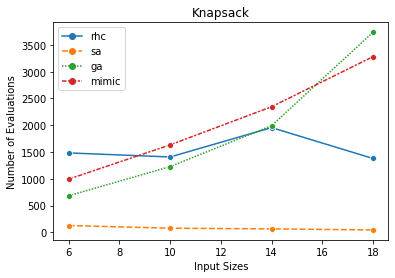

In [77]:
df = eval_cnt_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set(xlabel='Input Sizes',ylabel='Number of Evaluations')

In [78]:
eval_time_df

,input_size,rhc,sa,ga,mimic
0,6,0.080182,0.007340,0.062210,0.416371
1,10,0.074333,0.004619,0.112512,1.107700
2,14,0.108686,0.004119,0.186844,2.205944
3,18,0.076321,0.002938,0.365376,3.966972


[Text(0, 0.5, 'Time (s)'), Text(0.5, 0, 'Input Sizes')]

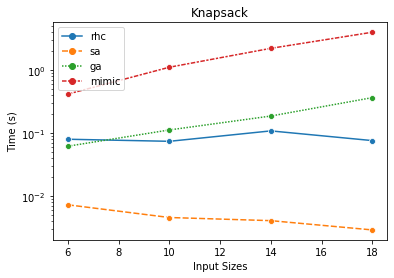

In [79]:
df = eval_time_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set_yscale('log')
ax.set(xlabel='Input Sizes', ylabel='Time (s)')

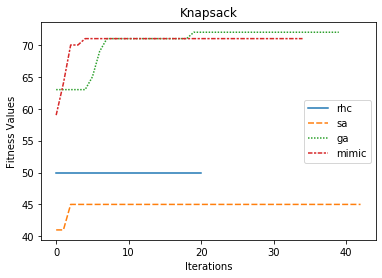

In [73]:
## Fitness Convergence Analysis
labels = ['rhc', 'sa', 'ga', 'mimic']

ax = sns.lineplot(data=[rhc_curve, sa_curve, ga_curve, mimic_curve])
# ax.set_ylim(0, 36)
ax.set_title(title)
ax.set(xlabel='Iterations',ylabel='Fitness Values')

legend = ax.get_legend()
for handle,l in zip(legend.texts, labels):
    handle.set_text(l)


In [81]:
print(title, 'bit array size:%d'%len(rhc_state))
print('rhc:   {0:5.1f}'.format(rhc_fitness), rhc_state)
print('sa:    {0:5.1f}'.format(sa_fitness), sa_state)
print('ga:    {0:5.1f}'.format(ga_fitness), ga_state)
print('mimic: {0:5.1f}'.format(mimic_fitness), mimic_state)

Knapsack bit array size:18
rhc:    50.0 [0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1]
sa:     45.0 [1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1]
ga:     72.0 [1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1]
mimic:  71.0 [1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1]
